<a href="https://colab.research.google.com/github/t-tsue/public/blob/main/PBL02_sample_vith14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
DIR='/content/drive/My Drive/DXQuest_PBL02/'

Mounted at /content/drive


In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd

train_files = glob.glob(os.path.join(DIR,'train_conv', '*/*.jpeg'))
test_files = sorted(glob.glob(os.path.join(DIR,'test_conv', '*.jpeg')))

train_df = pd.DataFrame(train_files, columns=['file_name'])
test_df = pd.DataFrame(test_files, columns=['file_name'])

In [3]:
def get_label(x):
  if 'bridge' in x:
    return 1
  elif 'horn' in x:
    return 2
  elif 'potato' in x:
    return 3
  else:
    return 0

train_df['label'] = train_df['file_name'].apply(get_label)

In [4]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.optim as optim
import random
import torch.utils.data as data
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from sklearn.model_selection import StratifiedKFold

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#torch.set_default_device(device)

In [6]:
SIZE = 518
CSIZE = 518
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

class ImageTransform():
  def __init__(self, phase, resize = SIZE, csize=CSIZE, mean = MEAN, std = STD):
    self.phase = phase
    if phase == 'train':
      self.data_transform = transforms.Compose([
          transforms.RandomResizedCrop(resize,scale=(0.9,1)),
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(),
          transforms.RandomRotation(degrees=(-10,10)),
          transforms.ToTensor(),
          transforms.Normalize(mean, std)
      ])
    else:
      self.data_transform = transforms.Compose([
          transforms.Resize(resize),
          transforms.CenterCrop(csize),
          transforms.ToTensor(),
          transforms.Normalize(mean, std)
      ])

  def __call__(self, img):
    return self.data_transform(img)

In [7]:
class CustomDataset(Dataset):
  def __init__(self, df, phase='train'):
    self.df = df
    self.transform = ImageTransform(phase)
    self.phase = phase

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    if self.phase != 'test':
      img_path = self.df.iloc[index]['file_name']
      img = Image.open(img_path)
      img_transformed = self.transform(img)
      label = self.df.iloc[index]['label']
      return img_transformed, label
    else:
      img_path = self.df.iloc[index]['file_name']
      img = Image.open(img_path)
      img_transformed = self.transform(img)
      return img_transformed


In [8]:
def train_model(net, dataloader_dict, criterion, optimizer, num_epochs):
  best_loss = 99
  best_acc = 0
  scores=[]
  net.to(device)
  # epochのループ
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-------------')
    for phase in ['train', 'val']:
      if phase == 'train':
        net.train()  # モデルを訓練モードに
      else:
        net.eval()   # モデルを検証モードに

      # epochごとの学習と検証のループ

      epoch_loss = 0.0  # epochの損失和
      epoch_corrects = 0  # epochの正解数


      # データローダーからミニバッチを取り出すループ
      dataloader = dataloader_dict[phase]
      for inputs, labels in tqdm(dataloader):

        # optimizerを初期化
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 順伝搬（forward）計算
        with torch.set_grad_enabled(phase=='train'):
          outputs = net(inputs)
          loss = criterion(outputs, labels)  # 損失を計算
          _, preds = torch.max(outputs, 1)  # ラベルを予測


          # 訓練時はバックプロパゲーション
          if phase == 'train':
            loss.backward()
            optimizer.step()

          # イタレーション結果の計算
          # lossの合計を更新
          epoch_loss += loss.item() * inputs.size(0)
          # 正解数の合計を更新
          epoch_corrects += torch.sum(preds == labels.data)

      # epochごとのlossと正解率を表示
      epoch_loss = epoch_loss / len(dataloader.dataset)
      epoch_acc = epoch_corrects.double(
      ) / len(dataloader.dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
          phase, epoch_loss, epoch_acc))
      if phase == 'val':
        if epoch_loss < best_loss:
          best_loss = epoch_loss
          torch.save(net.to('cpu').state_dict(), os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOCHS}_best_loss.pth'))
          net.to(device)
        if epoch_acc > best_acc:
          best_acc = epoch_acc
          torch.save(net.to('cpu').state_dict(), os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOCHS}_best_acc.pth'))
          net.to(device)
      scores.append([epoch, phase, epoch_loss, epoch_acc])
  return net, pd.DataFrame(scores, columns=['epoch', 'phase', 'loss', 'acc'])

In [9]:
BATCH_SIZE = 40
EPOCHS = 50
LEARNING_RATE = 0.001
#MOMENTUM = 0.9

def get_model():
  weights = models.ViT_H_14_Weights.IMAGENET1K_SWAG_E2E_V1  # 学習済みのパラメータを使用
  net = models.vit_h_14(weights=weights)
  net.heads.head = nn.Linear(in_features=1280, out_features=4, bias=True)
  return net

def get_criterion():
  criterion = nn.CrossEntropyLoss()
  return criterion

def get_optimizer(net):
  params_to_update = []

  update_param_names = ["encoder.ln.weight", "encoder.ln.bias", "heads.head.weight", "heads.head.bias"]

  for name, param in net.named_parameters():
    if name in update_param_names:
      param.requires_grad = True
      params_to_update.append(param)
    else:
      param.requires_grad = False

  optimizer = optim.Adam(params_to_update, lr=LEARNING_RATE, )
  return optimizer

In [10]:
def predict(net, dataloader):
  net = net.to(device)
  net.eval()
  result=[]
  for inputs in dataloader:
    outputs = net(inputs.to(device))
    outputs = list(outputs.detach().cpu().numpy())
    result.extend(outputs)
  return np.argmax(np.array(result),axis=1)

def predict_proba(net, dataloader):
  net = net.to(device)
  net.eval()
  result=[]
  for inputs in dataloader:
    outputs = net(inputs.to(device))
    outputs = list(outputs.detach().cpu().numpy())
    result.extend(outputs)
  result = np.array(result)
  pred_0 = result[:,0]
  pred_1 = result[:,1]
  return np.exp(pred_1)/(np.exp(pred_0)+np.exp(pred_1))

def get_score(y_true, y_pred):
  y_true = (y_true > 0).astype(int)
  y_pred = (y_pred > 0).astype(int)
  acc = accuracy_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  return [acc, recall, precision, f1]

SEED=42

def init_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

for seed in range(1):
  seed = SEED + seed
  init_seed(seed)
  g = torch.Generator()
  g.manual_seed(seed)
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
  X = train_df
  y = train_df['label']
  MODEL_DIR=os.path.join(DIR,'model')
  os.makedirs(MODEL_DIR, exist_ok=True)
  for iter, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    train_dataset = CustomDataset(X_train, phase='train')
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                                    worker_init_fn=seed_worker,generator=g)
    val_dataset = CustomDataset(X_val, phase='val')
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                                    worker_init_fn=seed_worker,generator=g)
    net = get_model()
    criterion = get_criterion()
    optimizer = get_optimizer(net)
    dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}
    net,score = train_model(net, dataloader_dict, criterion, optimizer, EPOCHS)
    torch.save(net.to('cpu').state_dict(), os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOCHS}_{iter}.pth'))
    break

Downloading: "https://download.pytorch.org/models/vit_h_14_swag-80465313.pth" to /root/.cache/torch/hub/checkpoints/vit_h_14_swag-80465313.pth
100%|██████████| 2.36G/2.36G [00:31<00:00, 81.6MB/s]


Epoch 1/50
-------------


100%|██████████| 6/6 [04:27<00:00, 44.55s/it]


train Loss: 1.4152 Acc: 0.3836


100%|██████████| 2/2 [00:56<00:00, 28.34s/it]


val Loss: 1.3590 Acc: 0.3793
Epoch 2/50
-------------


100%|██████████| 6/6 [03:51<00:00, 38.52s/it]


train Loss: 1.2704 Acc: 0.4397


100%|██████████| 2/2 [00:44<00:00, 22.12s/it]


val Loss: 1.2177 Acc: 0.4310
Epoch 3/50
-------------


100%|██████████| 6/6 [03:51<00:00, 38.55s/it]


train Loss: 1.1363 Acc: 0.5129


100%|██████████| 2/2 [00:45<00:00, 22.79s/it]


val Loss: 1.0380 Acc: 0.5517
Epoch 4/50
-------------


100%|██████████| 6/6 [04:02<00:00, 40.34s/it]


train Loss: 1.0611 Acc: 0.5345


100%|██████████| 2/2 [00:45<00:00, 22.69s/it]


val Loss: 1.0713 Acc: 0.5000
Epoch 5/50
-------------


100%|██████████| 6/6 [03:47<00:00, 37.88s/it]


train Loss: 0.9938 Acc: 0.5948


100%|██████████| 2/2 [00:44<00:00, 22.14s/it]


val Loss: 1.0070 Acc: 0.6034
Epoch 6/50
-------------


100%|██████████| 6/6 [03:51<00:00, 38.65s/it]


train Loss: 0.8811 Acc: 0.6810


100%|██████████| 2/2 [00:44<00:00, 22.46s/it]


val Loss: 0.9753 Acc: 0.6552
Epoch 7/50
-------------


100%|██████████| 6/6 [03:53<00:00, 38.95s/it]


train Loss: 0.8956 Acc: 0.6250


100%|██████████| 2/2 [00:45<00:00, 22.77s/it]


val Loss: 0.9368 Acc: 0.6552
Epoch 8/50
-------------


100%|██████████| 6/6 [03:45<00:00, 37.64s/it]


train Loss: 0.8800 Acc: 0.6250


100%|██████████| 2/2 [00:45<00:00, 22.93s/it]


val Loss: 0.9149 Acc: 0.6552
Epoch 9/50
-------------


100%|██████████| 6/6 [03:45<00:00, 37.62s/it]


train Loss: 0.7957 Acc: 0.7112


100%|██████████| 2/2 [00:45<00:00, 22.63s/it]


val Loss: 0.8755 Acc: 0.6724
Epoch 10/50
-------------


100%|██████████| 6/6 [03:53<00:00, 39.00s/it]


train Loss: 0.7905 Acc: 0.6940


100%|██████████| 2/2 [00:45<00:00, 22.95s/it]


val Loss: 0.8796 Acc: 0.6552
Epoch 11/50
-------------


100%|██████████| 6/6 [03:45<00:00, 37.64s/it]


train Loss: 0.7655 Acc: 0.7457


100%|██████████| 2/2 [00:44<00:00, 22.05s/it]


val Loss: 0.8665 Acc: 0.6552
Epoch 12/50
-------------


100%|██████████| 6/6 [03:46<00:00, 37.78s/it]


train Loss: 0.7142 Acc: 0.7457


100%|██████████| 2/2 [00:45<00:00, 22.50s/it]


val Loss: 0.8892 Acc: 0.6379
Epoch 13/50
-------------


100%|██████████| 6/6 [03:45<00:00, 37.53s/it]


train Loss: 0.6922 Acc: 0.7845


100%|██████████| 2/2 [00:44<00:00, 22.04s/it]


val Loss: 0.8280 Acc: 0.6724
Epoch 14/50
-------------


100%|██████████| 6/6 [03:45<00:00, 37.62s/it]


train Loss: 0.6535 Acc: 0.7716


100%|██████████| 2/2 [00:46<00:00, 23.05s/it]


val Loss: 0.7942 Acc: 0.6724
Epoch 15/50
-------------


100%|██████████| 6/6 [03:45<00:00, 37.57s/it]


train Loss: 0.6820 Acc: 0.7586


100%|██████████| 2/2 [00:44<00:00, 22.08s/it]


val Loss: 0.8117 Acc: 0.6552
Epoch 16/50
-------------


100%|██████████| 6/6 [03:45<00:00, 37.53s/it]


train Loss: 0.6411 Acc: 0.7802


100%|██████████| 2/2 [00:45<00:00, 22.64s/it]


val Loss: 0.8343 Acc: 0.6379
Epoch 17/50
-------------


100%|██████████| 6/6 [03:46<00:00, 37.71s/it]


train Loss: 0.6092 Acc: 0.7802


100%|██████████| 2/2 [00:44<00:00, 22.20s/it]


val Loss: 0.7819 Acc: 0.6552
Epoch 18/50
-------------


100%|██████████| 6/6 [03:48<00:00, 38.06s/it]


train Loss: 0.6173 Acc: 0.7888


100%|██████████| 2/2 [00:45<00:00, 22.80s/it]


val Loss: 0.8179 Acc: 0.6552
Epoch 19/50
-------------


100%|██████████| 6/6 [03:44<00:00, 37.44s/it]


train Loss: 0.5870 Acc: 0.7931


100%|██████████| 2/2 [00:44<00:00, 22.01s/it]


val Loss: 0.7686 Acc: 0.7069
Epoch 20/50
-------------


100%|██████████| 6/6 [03:51<00:00, 38.66s/it]


train Loss: 0.5980 Acc: 0.7802


100%|██████████| 2/2 [00:44<00:00, 22.25s/it]


val Loss: 0.7960 Acc: 0.6897
Epoch 21/50
-------------


100%|██████████| 6/6 [03:44<00:00, 37.38s/it]


train Loss: 0.5418 Acc: 0.8276


100%|██████████| 2/2 [00:43<00:00, 21.99s/it]


val Loss: 0.7763 Acc: 0.6897
Epoch 22/50
-------------


100%|██████████| 6/6 [03:44<00:00, 37.36s/it]


train Loss: 0.5638 Acc: 0.8060


100%|██████████| 2/2 [00:44<00:00, 22.33s/it]


val Loss: 0.7774 Acc: 0.7069
Epoch 23/50
-------------


100%|██████████| 6/6 [03:44<00:00, 37.48s/it]


train Loss: 0.5747 Acc: 0.7974


100%|██████████| 2/2 [00:45<00:00, 22.56s/it]


val Loss: 0.7568 Acc: 0.7241
Epoch 24/50
-------------


100%|██████████| 6/6 [03:52<00:00, 38.75s/it]


train Loss: 0.5903 Acc: 0.7888


100%|██████████| 2/2 [00:44<00:00, 22.03s/it]


val Loss: 0.7649 Acc: 0.7414
Epoch 25/50
-------------


100%|██████████| 6/6 [03:43<00:00, 37.24s/it]


train Loss: 0.5203 Acc: 0.8276


100%|██████████| 2/2 [00:45<00:00, 22.88s/it]


val Loss: 0.7661 Acc: 0.6897
Epoch 26/50
-------------


100%|██████████| 6/6 [03:45<00:00, 37.53s/it]


train Loss: 0.5277 Acc: 0.8405


100%|██████████| 2/2 [00:44<00:00, 22.06s/it]


val Loss: 0.7417 Acc: 0.7241
Epoch 27/50
-------------


100%|██████████| 6/6 [03:46<00:00, 37.78s/it]


train Loss: 0.5153 Acc: 0.8448


100%|██████████| 2/2 [00:45<00:00, 22.80s/it]


val Loss: 0.7457 Acc: 0.7069
Epoch 28/50
-------------


100%|██████████| 6/6 [03:44<00:00, 37.50s/it]


train Loss: 0.4631 Acc: 0.8879


100%|██████████| 2/2 [00:44<00:00, 22.09s/it]


val Loss: 0.7493 Acc: 0.6724
Epoch 29/50
-------------


100%|██████████| 6/6 [03:44<00:00, 37.48s/it]


train Loss: 0.4968 Acc: 0.8491


100%|██████████| 2/2 [00:45<00:00, 22.92s/it]


val Loss: 0.7614 Acc: 0.6897
Epoch 30/50
-------------


100%|██████████| 6/6 [03:45<00:00, 37.61s/it]


train Loss: 0.4793 Acc: 0.8621


100%|██████████| 2/2 [00:44<00:00, 22.01s/it]


val Loss: 0.7660 Acc: 0.6897
Epoch 31/50
-------------


100%|██████████| 6/6 [03:44<00:00, 37.46s/it]


train Loss: 0.4549 Acc: 0.8750


100%|██████████| 2/2 [00:44<00:00, 22.17s/it]


val Loss: 0.7381 Acc: 0.6724
Epoch 32/50
-------------


100%|██████████| 6/6 [03:45<00:00, 37.53s/it]


train Loss: 0.4699 Acc: 0.8707


100%|██████████| 2/2 [00:45<00:00, 22.84s/it]


val Loss: 0.7915 Acc: 0.6724
Epoch 33/50
-------------


100%|██████████| 6/6 [03:44<00:00, 37.38s/it]


train Loss: 0.4351 Acc: 0.8664


100%|██████████| 2/2 [00:44<00:00, 22.01s/it]


val Loss: 0.7201 Acc: 0.7241
Epoch 34/50
-------------


100%|██████████| 6/6 [03:44<00:00, 37.39s/it]


train Loss: 0.4552 Acc: 0.8578


100%|██████████| 2/2 [00:43<00:00, 21.95s/it]


val Loss: 0.7290 Acc: 0.7414
Epoch 35/50
-------------


100%|██████████| 6/6 [03:44<00:00, 37.37s/it]


train Loss: 0.4338 Acc: 0.8448


100%|██████████| 2/2 [00:45<00:00, 22.85s/it]


val Loss: 0.6859 Acc: 0.7586
Epoch 36/50
-------------


100%|██████████| 6/6 [03:53<00:00, 38.86s/it]


train Loss: 0.4470 Acc: 0.8578


100%|██████████| 2/2 [00:44<00:00, 22.12s/it]


val Loss: 0.7689 Acc: 0.6897
Epoch 37/50
-------------


100%|██████████| 6/6 [03:45<00:00, 37.52s/it]


train Loss: 0.4715 Acc: 0.8707


100%|██████████| 2/2 [00:44<00:00, 22.02s/it]


val Loss: 0.7155 Acc: 0.7069
Epoch 38/50
-------------


100%|██████████| 6/6 [03:45<00:00, 37.57s/it]


train Loss: 0.4323 Acc: 0.8534


100%|██████████| 2/2 [00:45<00:00, 22.68s/it]


val Loss: 0.8072 Acc: 0.6724
Epoch 39/50
-------------


100%|██████████| 6/6 [03:44<00:00, 37.43s/it]


train Loss: 0.4186 Acc: 0.8836


100%|██████████| 2/2 [00:44<00:00, 22.05s/it]


val Loss: 0.7143 Acc: 0.7241
Epoch 40/50
-------------


100%|██████████| 6/6 [03:44<00:00, 37.44s/it]


train Loss: 0.4118 Acc: 0.8750


100%|██████████| 2/2 [00:45<00:00, 22.97s/it]


val Loss: 0.7473 Acc: 0.7069
Epoch 41/50
-------------


100%|██████████| 6/6 [03:45<00:00, 37.50s/it]


train Loss: 0.4136 Acc: 0.8750


100%|██████████| 2/2 [00:44<00:00, 22.03s/it]


val Loss: 0.7074 Acc: 0.7414
Epoch 42/50
-------------


100%|██████████| 6/6 [03:45<00:00, 37.57s/it]


train Loss: 0.3999 Acc: 0.8664


100%|██████████| 2/2 [00:44<00:00, 22.45s/it]


val Loss: 0.7413 Acc: 0.7069
Epoch 43/50
-------------


100%|██████████| 6/6 [03:45<00:00, 37.66s/it]


train Loss: 0.3898 Acc: 0.8836


100%|██████████| 2/2 [00:44<00:00, 22.27s/it]


val Loss: 0.7448 Acc: 0.7069
Epoch 44/50
-------------


100%|██████████| 6/6 [03:45<00:00, 37.57s/it]


train Loss: 0.4122 Acc: 0.8750


100%|██████████| 2/2 [00:44<00:00, 22.16s/it]


val Loss: 0.7680 Acc: 0.7069
Epoch 45/50
-------------


100%|██████████| 6/6 [03:45<00:00, 37.53s/it]


train Loss: 0.3843 Acc: 0.8664


100%|██████████| 2/2 [00:45<00:00, 22.93s/it]


val Loss: 0.7334 Acc: 0.7069
Epoch 46/50
-------------


100%|██████████| 6/6 [03:45<00:00, 37.55s/it]


train Loss: 0.3921 Acc: 0.9009


100%|██████████| 2/2 [00:44<00:00, 22.03s/it]


val Loss: 0.6818 Acc: 0.7586
Epoch 47/50
-------------


100%|██████████| 6/6 [03:45<00:00, 37.57s/it]


train Loss: 0.3987 Acc: 0.8879


100%|██████████| 2/2 [00:45<00:00, 22.75s/it]


val Loss: 0.7310 Acc: 0.7414
Epoch 48/50
-------------


100%|██████████| 6/6 [03:44<00:00, 37.47s/it]


train Loss: 0.3580 Acc: 0.8879


100%|██████████| 2/2 [00:44<00:00, 22.09s/it]


val Loss: 0.7569 Acc: 0.7069
Epoch 49/50
-------------


100%|██████████| 6/6 [03:45<00:00, 37.53s/it]


train Loss: 0.3594 Acc: 0.9353


100%|██████████| 2/2 [00:44<00:00, 22.30s/it]


val Loss: 0.6897 Acc: 0.7069
Epoch 50/50
-------------


100%|██████████| 6/6 [03:46<00:00, 37.72s/it]


train Loss: 0.4033 Acc: 0.8664


100%|██████████| 2/2 [00:44<00:00, 22.38s/it]


val Loss: 0.7271 Acc: 0.7241


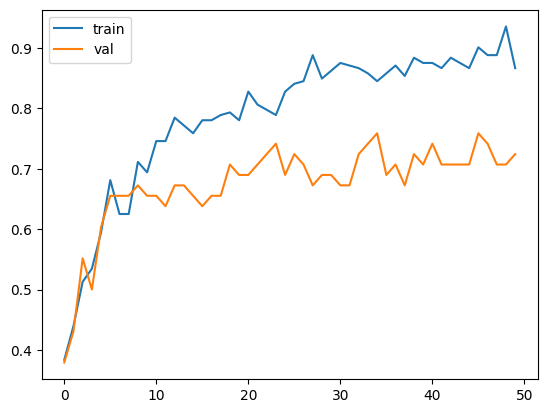

In [11]:
score_train = score[score['phase']=='train']
score_test = score[score['phase']=='val']
plt.plot(score_train['epoch'], score_train['acc'], label='train')
plt.plot(score_test['epoch'], score_test['acc'], label='val')
plt.legend()
plt.show()

In [12]:
net.to('cpu').load_state_dict(torch.load(os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOCHS}_best_loss.pth')))
net.to(device)
test_dataset = CustomDataset(test_df, phase='test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
pred_test = predict(net, test_dataloader)
df_pred = pd.DataFrame(pred_test, columns=['predicted_label'])
df_pred.to_csv(os.path.join(DIR,'pred_test_vith14_best_loss.csv'), index=False)

<ipython-input-12-adbf2a94bc08>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.to('cpu').load_state_dict(torch.load(os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOC

In [13]:
net.to('cpu').load_state_dict(torch.load(os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOCHS}_best_acc.pth')))
net.to(device)
test_dataset = CustomDataset(test_df, phase='test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
pred_test = predict(net, test_dataloader)
df_pred = pd.DataFrame(pred_test, columns=['predicted_label'])
df_pred.to_csv(os.path.join(DIR,'pred_test_vith14_best_acc.csv'), index=False)

<ipython-input-13-9a9462286e40>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.to('cpu').load_state_dict(torch.load(os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOC

In [14]:
net.to('cpu').load_state_dict(torch.load(os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOCHS}_{iter}.pth')))
net.to(device)
test_dataset = CustomDataset(test_df, phase='test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
pred_test = predict(net, test_dataloader)
df_pred = pd.DataFrame(pred_test, columns=['predicted_label'])
df_pred.to_csv(os.path.join(DIR,'pred_test_vith14_final.csv'), index=False)

<ipython-input-14-d4583ef9e7b5>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.to('cpu').load_state_dict(torch.load(os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOC